In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split #

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn


from subprocess import check_output
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns

In [2]:
def printa_matriz(y_ori, y_pred):
    
    cm_train = confusion_matrix(y_ori,y_pred, normalize='true')
    accuracy = accuracy_score(y_ori,y_pred)
    f1 = f1_score(y_ori,y_pred, average='weighted')

    
    plt.figure(figsize=(5, 3))
    plt.title(f'Accuracy: {round(accuracy, 4)} | F1-Score: {round(f1, 4)}', size=8)
    sns.heatmap(cm_train, annot=True, fmt='.2%', cmap='Blues')
    plt.xlabel('Predicted Values', size=5)
    plt.ylabel('True Values', size=5)
    plt.show()

In [3]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

## puxando a base

In [4]:
data = pd.read_csv(r'../corpus_aplicativo\review_app_sem_stop.csv')
data = data.dropna(subset=['polarity','frase'])

data = data[['frase','polarity']]

## sample dos dados

In [5]:
num_samples_per_class = 50000  # reshape dos dados, grande dms

df_zero = data[data.polarity == 0.0].sample(num_samples_per_class)
df_one = data[data.polarity == 1.0].sample(num_samples_per_class)

data = pd.concat([df_zero, df_one])

print(data.groupby(['polarity']).size())

polarity
0.0    50000
1.0    50000
dtype: int64


# BERT

In [6]:
#!pip install -qq transformers
import transformers
from transformers import BertModel, BertTokenizer, AdamW,  get_linear_schedule_with_warmup

In [7]:
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [8]:
token_lens = []

for txt in data.frase:
  tokens = tokenizer.encode_plus(txt, 
                                 max_length=512, 
                                 truncation=True, 
                                 padding='max_length')
  token_lens.append(len(tokens["input_ids"]))

In [9]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [10]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation=True, # Adicione esta linha se necessário
      return_token_type_ids=False,
      padding='max_length', 
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'frase': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [11]:
from sklearn.model_selection import train_test_split

# Primeiro, divida data em train e temporary (test + val) datasets
data_train, data_temp = train_test_split(data, 
                                         test_size=0.2, 
                                         stratify=data['polarity'], 
                                         random_state=RANDOM_SEED)

# Em seguida, divida o dataset temporary em test e val datasets
data_val, data_test = train_test_split(data_temp, 
                                       test_size=0.5, 
                                       stratify=data_temp['polarity'], 
                                       random_state=RANDOM_SEED)


In [12]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
num_workers = min(num_cores, 0) 
print(f'Number of available CPU cores: {num_workers}')

def create_data_loader(data, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=data.frase.to_numpy(),
    targets=data.polarity.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=num_workers
  )



Number of available CPU cores: 0


## Gerando as bases para a relização do treinamento

In [13]:
BATCH_SIZE = 16
MAX_LEN = 160
train_data_loader = create_data_loader(data_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(data_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(data_test, tokenizer, MAX_LEN, BATCH_SIZE)

data_valid2 = pd.read_csv('../lexicos/base_validacao.csv')
data_valid2 = data_valid2.dropna(subset=['polarity','frase'])
valid_data_loader2 = create_data_loader(data_valid2, tokenizer, MAX_LEN, BATCH_SIZE)


data_valid = pd.read_csv('../lexicos/base_validacao2.csv')
data_valid = data_valid.dropna(subset=['polarity','frase'])
valid_data_loader = create_data_loader(data_valid, tokenizer, MAX_LEN, BATCH_SIZE)

In [14]:
len(train_data_loader)

5000

In [15]:
dataf = next(iter(train_data_loader))
dataf.keys()

dict_keys(['frase', 'input_ids', 'attention_mask', 'targets'])

In [16]:
print(dataf['input_ids'].shape)
print(dataf['attention_mask'].shape)
print(dataf['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [17]:
import torch.nn as nn
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [19]:
model = SentimentClassifier(2)
model = model.to(device)

## Definição do modelo

In [20]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

d:\Users\heinr\anaconda3\envs\tccamb\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## definições e treinamento

In [21]:
from tqdm.notebook import tqdm

def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  # Aqui estamos usando tqdm para envolver o data_loader e mostrar uma barra de progresso
  for d in tqdm(data_loader, desc='Training'):
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [22]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [24]:
%%time
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(data_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(data_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')

  valid_acc, valid_loss = eval_model(
    model,
    valid_data_loader,
    loss_fn, 
    device, 
    len(data_valid)
  )

  print(f'Valid   loss {valid_acc} accuracy {valid_loss}')

  valid_acc2, valid_loss2 = eval_model(
    model,
    valid_data_loader2,
    loss_fn, 
    device, 
    len(data_valid2)
  )

  print(f'Valid 2   loss {valid_acc2} accuracy {valid_loss2}') 
    
  test_acc, test_loss = eval_model( ## adicionei para ver o comportamento
    model, 
    test_data_loader, 
    loss_fn, 
    device, 
    len(data_test)
  )
  
  print(f'Test  loss {test_loss} accuracy {test_acc}') ## adicionei para ver o comportamento

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Train loss 0.30852522151991724 accuracy 0.8846375000000001
Val   loss 0.2662830392867327 accuracy 0.903
Valid   loss 0.84 accuracy 0.5752398371696472
Valid 2   loss 0.7567567567567568 accuracy 0.6257485662187848
Test  loss 0.26732184083759786 accuracy 0.8977
Epoch 2/10
----------


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Train loss 0.2597990558188409 accuracy 0.912425
Val   loss 0.2882350666642189 accuracy 0.9054000000000001
Valid   loss 0.84 accuracy 0.48558540642261505
Valid 2   loss 0.7207207207207207 accuracy 0.7323708363941738
Test  loss 0.3059738239437342 accuracy 0.8977
Epoch 3/10
----------


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

## Realização dos testes

In [ ]:
train_acc_np = np.array([t.item() for t in history['train_acc']])
val_acc_np = np.array([t.item() for t in history['val_acc']])

plt.plot(train_acc_np, label='train accuracy')
plt.plot(val_acc_np, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()

In [29]:
import torch.nn.functional as F

In [26]:
class_names = ['Negativo', 'Positivo']
# Certifique-se de que o modelo está inicializado
model = SentimentClassifier(len(class_names))
model = model.to(device)

# Carregando o modelo
model.load_state_dict(torch.load(r'D:\Users\heinr\Desktop\TCC-Adriano\classsificação_bert\best_model_state.bin'))

<All keys matched successfully>

In [27]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["frase"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [30]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Negativo       0.91      0.90      0.91      5000
    Positivo       0.91      0.91      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [32]:
from sklearn.metrics import confusion_matrix


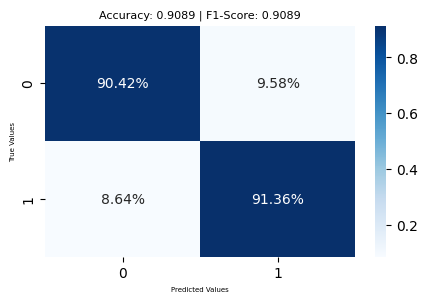

In [33]:
printa_matriz(y_test, y_pred)

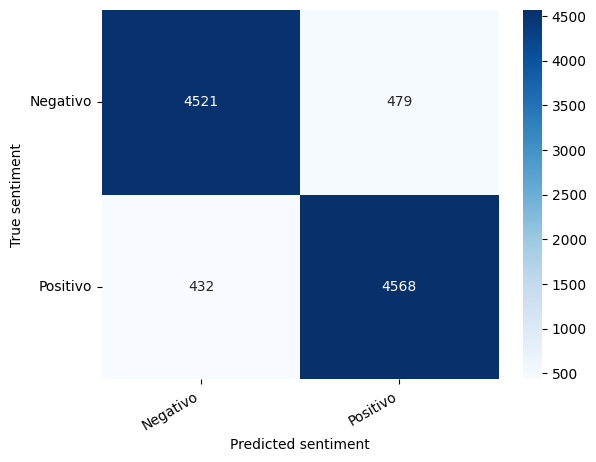

In [34]:

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## Validação

In [35]:
data_valid = pd.read_csv(r'../lexicos/base_validacao.csv')
data_valid = data_valid.dropna(subset=['polarity','frase'])
valid_data_loader = create_data_loader(data_valid, tokenizer, MAX_LEN, BATCH_SIZE)

In [45]:
y_review_texts_val, y_pred_val, y_pred_probs_val, y_val = get_predictions(
  model,
  valid_data_loader
)

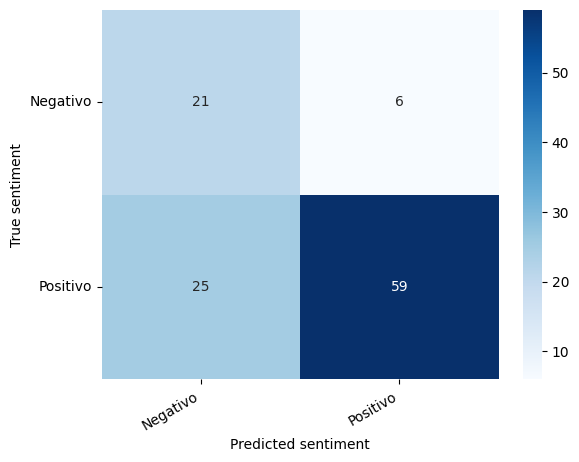

In [46]:
cm = confusion_matrix(y_val, y_pred_val)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

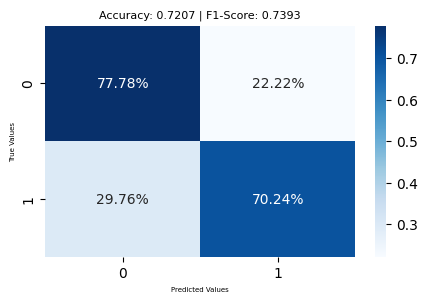

In [47]:
printa_matriz(y_val, y_pred_val)

In [48]:
df_valid = pd.DataFrame({'frase': y_review_texts_val, 'y_val': y_val, 'y_pred_val': y_pred_val})


In [49]:
df_valid.to_csv("validacao_classificada.csv",index=False)

## validacao 02

In [41]:
BATCH_SIZE = 16


data_valid2 = pd.read_csv(r'../lexicos/base_validacao2.csv')
data_valid2 = data_valid2.dropna(subset=['polarity','frase'])
valid_data_loader2 = create_data_loader(data_valid2, tokenizer, MAX_LEN, BATCH_SIZE)


In [42]:
y_review_texts_val2, y_pred_val2, y_pred_probs_val2, y_val2 = get_predictions(
  model,
  valid_data_loader2
)

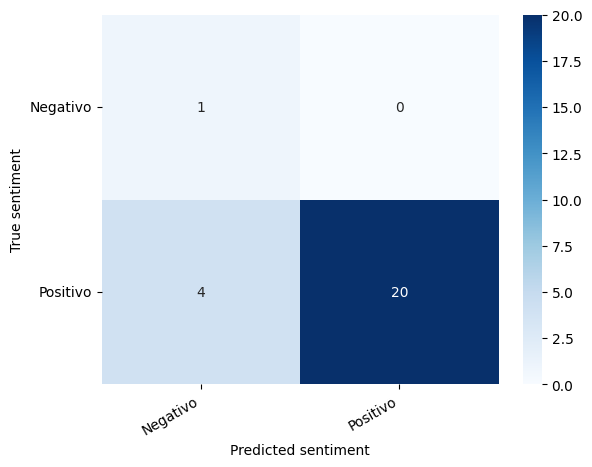

In [43]:
cm2 = confusion_matrix(y_val2, y_pred_val2)
df_cm2 = pd.DataFrame(cm2, index=class_names, columns=class_names)
show_confusion_matrix(df_cm2)

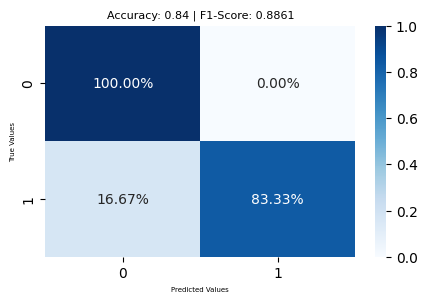

In [37]:
printa_matriz(y_val2, y_pred_val2)

In [ ]:
df_valid2 = pd.DataFrame({'frase': y_review_texts_val2, 'y_val': y_val2, 'y_pred_val': y_pred_val2})


In [ ]:
df_valid2.to_csv("validacao_classificada2.csv",index=False)